In [1]:
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import ssl
from Solvers import SolverEmbedding,Loss
from scipy.stats import norm
import os
from Models.EncoderModels import TextEncoderWithATTN,TransferLearningALBERT,TextEncoder
from config import cfg
from dataEmbedding.dataEmbedding import Read_Load_BuildBatch
from dataEmbedding.dataEmbeddingLoader import GenerateDataLoader,check_dataset,collate_embedding
from dataEmbedding.generateEmbedding import build_embeedings_CWGAN, singleRun
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import cKDTree
import pickle
import matplotlib


In [2]:
with open('./../InfoData/Embedding_train_data.pkl', 'rb') as pickle_file:
    train=pickle.load(pickle_file)

In [3]:
with open('./../InfoData/Embedding_val_data.pkl', 'rb') as pickle_file:
    val=pickle.load(pickle_file)

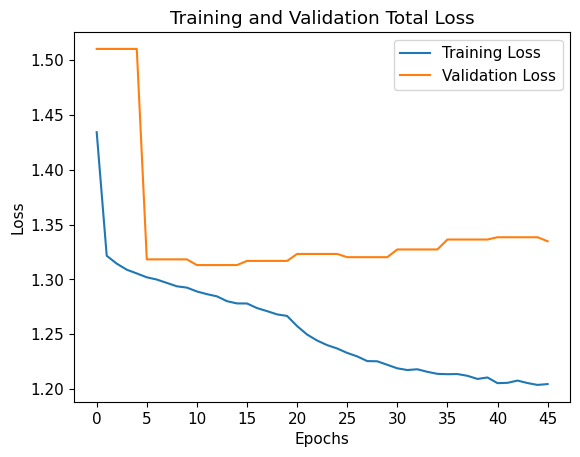

In [18]:
from matplotlib.pylab import plt
from numpy import arange


epochs = range(0, 46)
 
plt.plot(range(0,46), train['total_loss'], label='Training Loss')
plt.plot(range(0,46), val['total_loss'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 46, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

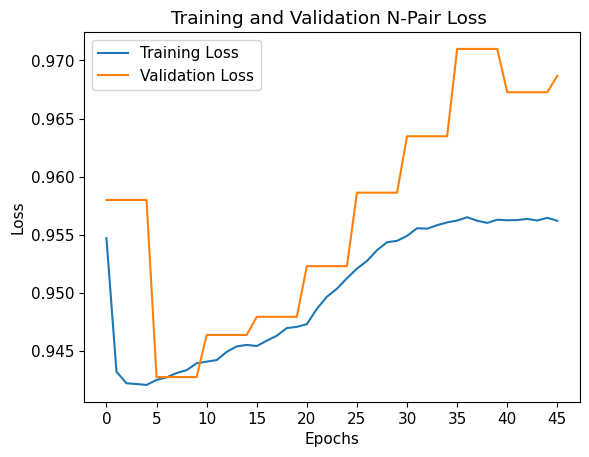

In [19]:
from matplotlib.pylab import plt
from numpy import arange


epochs = range(0, 46)
 
plt.plot(range(0,46), train['n_pair_loss'], label='Training Loss')
plt.plot(range(0,46), val['n_pair_loss'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation N-Pair Loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 46, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

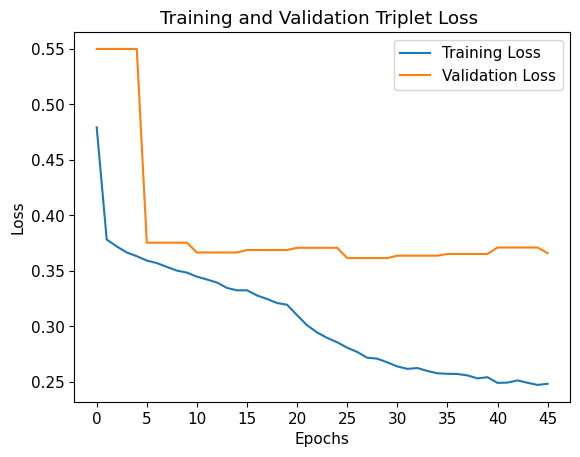

In [20]:
from matplotlib.pylab import plt
from numpy import arange


epochs = range(0, 46)
 
plt.plot(range(0,46), train['triple_loss'], label='Training Loss')
plt.plot(range(0,46), val['triple_loss'], label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Triplet Loss ')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 46, 5))
 
# Display the plot
plt.legend(loc='best')
plt.show()

In [9]:
stanData=Read_Load_BuildBatch(cfg.EMBEDDING_BATCH_SIZE)

Median of list is : 14.0
Mean: 16.300818040383426


Text(0.5, 1.0, 'Rozkład długości opisów tekstowych')

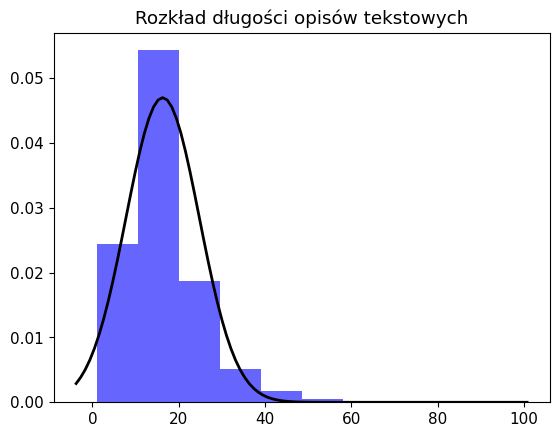

In [21]:
stanData.wordlens.sort()
mid = len(stanData.wordlens) // 2
res = (stanData.wordlens[mid] + stanData.wordlens[~mid]) / 2
print("Median of list is : " + str(res))
print("Mean: "+ str(sum(stanData.wordlens)/len(stanData.wordlens)))

mu, std = norm.fit(stanData.wordlens) 
  
# Plot the histogram.
plt.hist(stanData.wordlens, density=True, alpha=0.6, color='b')
  
# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
  
plt.plot(x, p, 'k', linewidth=2)
title = "Rozkład długości opisów tekstowych"
plt.title(title)

Build Similarity Matrix

In [2]:
with open('./../GeneratedEmbeddingsTest/test.p', 'rb') as pickle_file:
    tmp=pickle.load(pickle_file)

simMatTest=np.zeros([len(tmp),128])

for i,elem in enumerate(tmp):
    simMatTest[i]=elem[3].cpu()

simMatTest=torch.tensor(simMatTest)
normMatrix=torch.matmul(torch.norm(simMatTest,dim=1,keepdim=True),torch.norm(simMatTest,dim=1,keepdim=True).T)
similarityMatrix=torch.matmul(simMatTest,simMatTest.T)
cosineDistane=similarityMatrix/normMatrix




In [3]:
def findKclosestElementsEuclidean(data,vectorIdx,k):
    elems=[]
    distance=np.zeros([len(data),1])
    for i in range(len(data)):
        if vectorIdx==i:
            distance[i]=1000
        distance[i]=(data[i][3].cpu()-data[vectorIdx][3].cpu()).pow(2).sum().sqrt()
    sorted_indices = distance[:,0].argsort()
    indices_of_smallest = sorted_indices[:k]
    Mainvalues = [stanData.dict_idx2word[key] for key in data[vectorIdx][4].tolist() if key!=0]

    for i in indices_of_smallest:
        values = [stanData.dict_idx2word[key] for key in data[i][4].tolist() if key!=0]

        elems.append(' '.join(values))

    print("Main vector: "+' '.join(Mainvalues))
    print()
    print("Closest embeddings:")
    for i in elems:
        print(i)

In [29]:
def findKclosestElementsCosine(data,matrix,vectorIdx,k):
    elems=[]
    sorted_indices = matrix[vectorIdx].argsort()
    indices_of_smallest = sorted_indices[:k]
    Mainvalues = [stanData.dict_idx2word[key] for key in data[vectorIdx][4].cpu().tolist() if key!=0]
    
    for i in indices_of_smallest:
        values = [stanData.dict_idx2word[key] for key in data[i][4].cpu().tolist() if key!=0]

        elems.append(' '.join(values))

    print("Main vector: "+' '.join(Mainvalues))
    print()
    print("Closest embeddings:")
    for i in elems:
        print(i)


In [16]:
def calculateNorm(data):
    elems=[] 
    chair=[]#0
    table=[]#1
    for i in data:
        if i[1]==1:
            table.append(torch.norm(i[3]))
        else:
            chair.append(torch.norm(i[3]))
    
    return chair,table


In [17]:
def distanceToElements(data):
    elemsTables=[]
    elemsChairs=[]
    for i in tqdm(data):
        pos=[]
        neg=[]
        for j in data:
            if i[1]==j[1]:
                pos.append((i[3]-j[3]).pow(2).sum(0).sqrt())
            else:
                neg.append((i[3]-j[3]).pow(2).sum(0).sqrt())
        if i[1]==0:
            elemsChairs.append((sum(pos)/len(pos),sum(neg)/len(neg)))
        else:
            elemsTables.append((sum(pos)/len(pos),sum(neg)/len(neg)))
        
    return elemsChairs,elemsTables

            

In [9]:
def distanceToElementsNPair(data):
    elemsTables=[]
    elemsChairs=[]
    for i in tqdm(data):
        pos=[]
        neg=[]
        for j in data:
            if i[2]==j[2]:
                pos.append((i[3]-j[3]).pow(2).sum(0).sqrt())
            else:
                neg.append((i[3]-j[3]).pow(2).sum(0).sqrt())
        if i[1]==0:
            elemsChairs.append((sum(pos)/len(pos),sum(neg)/len(neg)))
        else:
            elemsTables.append((sum(pos)/len(pos),sum(neg)/len(neg)))
        
    return elemsChairs,elemsTables

In [5]:
def distanceToElements(data):
    elemsTables=[]
    elemsChairs=[]
    for i in tqdm(data):
        pos=[]
        neg=[]
        for j in data:
            if i[1]==j[1]:
                pos.append((i[3]-j[3]).pow(2).sum(0).sqrt())
            else:
                neg.append((i[3]-j[3]).pow(2).sum(0).sqrt())
        if i[1]==0:
            elemsChairs.append((sum(pos)/len(pos),sum(neg)/len(neg)))
        else:
            elemsTables.append((sum(pos)/len(pos),sum(neg)/len(neg)))
        
    return elemsChairs,elemsTables

            

In [6]:
dist=distanceToElements(tmp)

100%|██████████| 7452/7452 [06:08<00:00, 20.22it/s]


In [10]:
dist2=distanceToElementsNPair(tmp)

100%|██████████| 7452/7452 [05:56<00:00, 20.93it/s]


In [11]:
font = {'size'   : 13}

matplotlib.rc('font', **font)

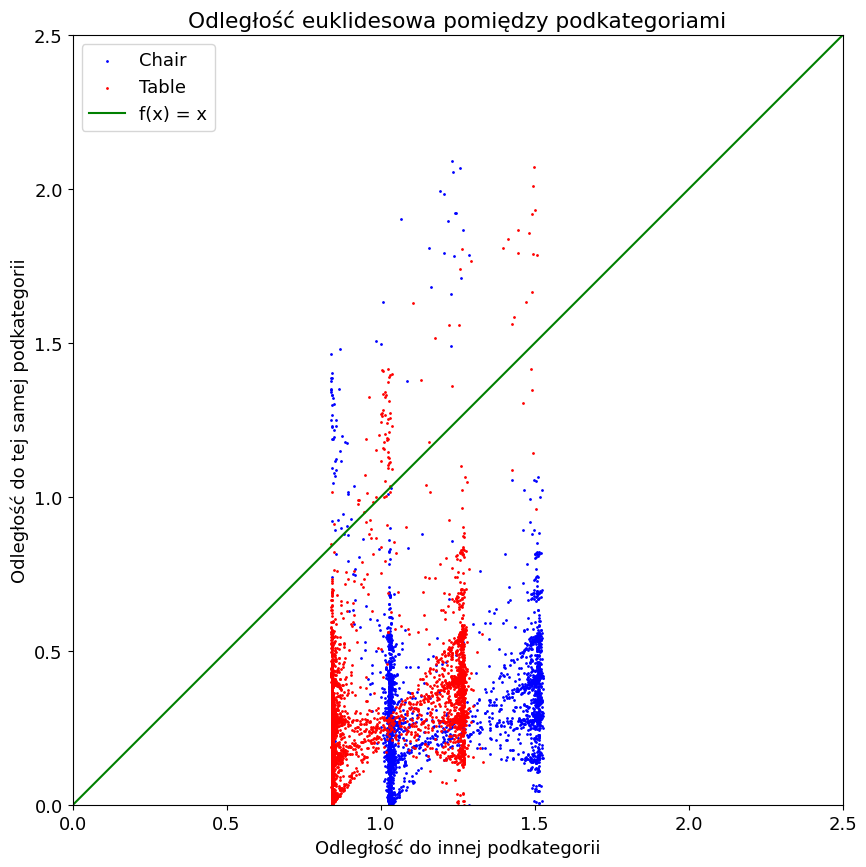

In [13]:


# Unpack x and y coordinates for each class
class1_y, class1_x = zip(*dist2[0])
class2_y, class2_x = zip(*dist2[1])

point_size=1
plt.figure(figsize=(10, 10))
# Plot points for each class
plt.scatter(class1_x, class1_y, label='Chair', color='blue',s=point_size)
plt.scatter(class2_x, class2_y, label='Table', color='red',s=point_size)


x_values = np.linspace(0,2.5, 100)
# Plot the function f(x) = x
plt.plot(x_values, x_values, label='f(x) = x', color='green', linestyle='-')


# Add labels and title
plt.xlabel('Odległość do innej podkategorii')
plt.ylabel('Odległość do tej samej podkategorii')
plt.title('Odległość euklidesowa pomiędzy podkategoriami')
plt.xlim(0, 2.5)
plt.ylim(0, 2.5)
ax = plt.gca()
ax.set_aspect('equal', adjustable='box')

# Add a legend
plt.legend()

# Show the plot
plt.show()

In [6]:
findKclosestElementsEuclidean(tmp,90,30)

Main vector: an odd wood table with two leg and a glass counter sit through the wood top

Closest embeddings:
an odd wood table with two leg and a glass counter sit through the wood top
round with three leg black in color appear to be wood
an antique be color table with ornamental work iron handle
old fashioned four leg table make of wood of a dark brown color
low rectangle table 2/3 white 1/3 black c shape on both side
a brown table with four bent metal square that it rest on
this be a desk the function be to write and read
black rectangular coffee table
table with round shape 4 leg standard height
a square shape surface stand on four wooden leg and have a design glass on it
circular dining table with height variety metal body
rectangular long mid height back and wood table
table with four leg and black top
a very plain round dark wooden table with a thick base
round shape table make of metal gray color modern style smooth surface
a gray wide table with a drawer with 4 leg
low gray ir

In [53]:
findKclosestElementsEuclidean(tmp,2912,30)

Main vector: a wooden brown table with glass on top there be also a wooden brown shelf below the glass to

Closest embeddings:
a wooden brown table with glass on top there be also a wooden brown shelf below the glass to
this table feature a circular shape and four leg which be all angle outwards the top of the table
this be a reddish brown low slung desk that be very plain and geometric looking like it be carve
a ping pong kind of table in teal and dark gray the center of the table have a gray
a drawer wooden color use to keep thing like book clothes it have three drawer
a long table with wooden leg and sky blue see through table top the top could possibly be some
a brown triangle side table with black base
this be a wooden medium brown draft or work table on wooden horse
large rectangular granite table top with dark rectangle inset four wooden post that have cutout in four corner of
glass top l shape table each straight part have four curved leg and above the short length the base
a c

Średnia norma

In [112]:
z=calculateNorm(tmp)
ra=z[0]+z[1]
print("Średnia norma: "+str(sum(ra)/len(ra)))
print("Minimalna norma: "+str(min(ra)))
print("Maksymalna norma: "+str(min(ra)))

print("Średnia norma krzesła: "+str(sum(z[0])/len(z[0])))
print("Średnia norma stoły: "+str(sum(z[1])/len(z[1])))

Średnia norma: tensor(0.9120)
Minimalna norma: tensor(0.0241)
Maksymalna norma: tensor(0.0241)
Średnia norma krzesła: tensor(1.0047)
Średnia norma stoły: tensor(0.8420)


In [29]:
findKclosestElementsEuclidean(tmp,9,20)

Main vector: the table look like a traditional japanese table it have a brown color and make my solid wood

Closest embeddings:
the table look like a traditional japanese table it have a brown color and make my solid wood
a possible metal silver two level rectangular table with cylinder bar connect the level and cylinder bar as the
a short wooden table with 4 leg that also have 7 line from one top end to the other
rectangular table with four leg of gray color and a white top have a small cuboid cabinet attach over
a rectangular dark wooden desk with two drawer underneath at right very minimalistic in style
this desk be a mix between black and brown it be make of wood and be square
a 4 cylindrical legged rectangular glass table the glass table top be slightly tint in black with a triangular
a rectangular tabletop with glass door underneath and brown leg the top of the table be a dark color
this table can be use in office its have three UNK its in rectangle shape
a round wooden table the

In [36]:
findKclosestElementsCosine(tmp,cosineDistane,100,9)

Main vector: a square wooden table that be low to the ground commonly see for dining in japan home tensor(1, dtype=torch.int32)

Closest embeddings:
rounded red chair with off white strip towards bottom of back on back off white crown small off white
a brown wooden chair with four beam as leg a tall back rest and a square beige seat
a brown color sofa couch with four legged base and wheel attach to it you can revolve around the
a blue metal chair with an open and curved back a curved square base and skinny leg there be
brown wooden rocking chair with brown padded surface on the seat and back and a low wide rectangular hole
this be a brown lounge chair with black leg and no arm
a large brown wooden backyard chair it have large wooden arm rest and a tall back
a black office chair on castor and arm rest
on orange sit chair with leg that be square frame on both side no arm and a slot in
